# Introduction to Data Parallelism

The goal is to train deep learning models in parallel and take advantage of more computing power.

<blockquote>
    
*  What is data parallelism ?

*  Train a deep learning model with 2 GPUs
</blockquote>


## Data parallelism 

This approach can be explain in 3 steps: 


1. We split the data into $n$ number of partitions, where $n$ is the total number of available workers in the compute cluster.

2. We copy the model in each worker node and each one of them performs the training on its own subset of the data.

3. We synchronize the model parameters, or gradients, at the end of the batch computation.



<img src="https://frankdenneman.nl/wp-content/uploads/2020/02/Data-Parallelism.png" width="850" height="380">



### Synchronous training 

Data parallelism involves dividing the data into partitions and distributing each part to a worker. Each worker trains on a portion of the data using a full replica of the model.


1.  During synchronous training, all workers perform the forward pass simultaneously, producing different outputs and gradients. The workers then wait for the other workers to complete their training loops and calculate gradients.

2.  Next, the workers communicate with each other and use the all-reduce algorithm to aggregate the gradients. Now after all the workers have completed computing gradients, all of them start communicating with each other and aggregate the gradients using the all-reduce algorithm, which we will discuss ahead. 

3.  Once the gradients are combined, the updated gradients are sent to all workers. Each worker can then perform the backward pass and update the local copy of the weights.

4.  The next forward pass does not begin until all workers have updated their weights, making this approach synchronous.

It is important to note that each worker produces different gradients because they train on different subsets of the data. However, at any given time, all workers have the same weights.


### GPUs Specifications

In [1]:
!nvidia-smi

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Sun Apr 14 14:05:21 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                 

Lets see how to train a model in Keras with both GPUs

## MNIST

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import time

## Data Loading new fashion_mnist dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

img_rows, img_cols = 28, 28
input_shape = (img_rows, img_cols, 1)

print(f"X_train Before: {X_train.shape}")
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
print(f"X_train After: {X_train.shape}")

print(f"X_test Before: {X_test.shape}")
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
print(f"X_test After: {X_test.shape}")

## converting the images to float32
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

## converting the range to [0,1]
X_train /= 255
X_test /= 255

4422102/4422102 [==============================] - 0s 0us/step
X_train Before: (60000, 28, 28)
X_train After: (60000, 28, 28, 1)
X_test Before: (10000, 28, 28)
X_test After: (10000, 28, 28, 1)


In [3]:
len(X_train)

60000

Let's take a quick look at the data

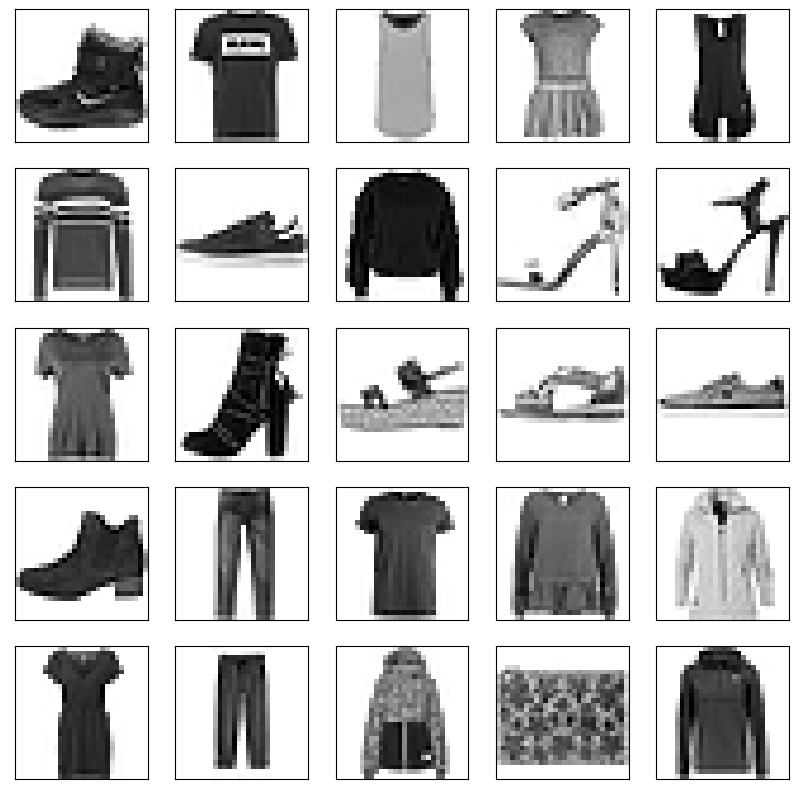

In [4]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
plt.show()

To make things better, lets put the data on a TF.dataset.

One important detail here is the BATCH_SIZE. To get the benefits of multiple GPUs, we have to optimize their use, otherwise you won't see the gains.

In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE_PER_REPLICA = 1024

def get_batch_size(num_gpus=1):
    batch_size = BATCH_SIZE_PER_REPLICA * num_gpus
    print(f'BATCH_SIZE = {batch_size}')
    return batch_size

# Wrap data in Dataset objects.
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))

# the batch size will be defined later based on the number of used GPUs
options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.OFF
train_data = train_data.with_options(options).cache().shuffle(BUFFER_SIZE).prefetch(tf.data.AUTOTUNE)
test_data = test_data.with_options(options)

## Defining a Distribution Strategy

To use Multi GPU, we are going to use the `tf.distribute.Strategy` API, 
more specifically `tf.distribute.MirroredStrategy`

This strategy will do the spliting of the work between both T4s for you

In [6]:
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

Number of devices: 2


## Building the model

The model has to be created inside a Strategy scope. The scope will make sure to place the model's variables on each processor. Then, it uses all-reduce to combine the gradients from all processors, and applies the combined value to all copies of the model.

In [7]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, [3, 3], activation='relu', input_shape=(28, 28, 1)),
        tf.keras.layers.Conv2D(64, [3, 3], activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.Dropout(0.25),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

    return model

In [8]:
# buiding a model inside the strategy scope
with strategy.scope():
    multi_gpu_model = build_model()

multi_gpu_model.summary()

# buiding a regular model on 1 GPU for performance comparison
regular_model = build_model()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 12, 12, 64)        0         
                                                                 
 flatten (Flatten)           (None, 9216)              0         
                                                                 
 dense (Dense)               (None, 128)               1179776   
                                                        

## Warmup

The framework will load aditional libraries not yet in memory and this would impact the timing of training the model.

In [9]:
get_batch_size(strategy.num_replicas_in_sync)

BATCH_SIZE = 2048


2048

In [10]:
EPOCHS = 5

d_train_data = train_data.batch(get_batch_size(strategy.num_replicas_in_sync))
history = multi_gpu_model.fit(d_train_data, epochs=EPOCHS)

BATCH_SIZE = 2048
Epoch 1/5


/opt/conda/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


30/30 [==============================] - 13s 70ms/step - loss: 0.9909 - accuracy: 0.6525
Epoch 2/5
30/30 [==============================] - 2s 58ms/step - loss: 0.5368 - accuracy: 0.8074
Epoch 3/5
30/30 [==============================] - 2s 55ms/step - loss: 0.4428 - accuracy: 0.8444
Epoch 4/5
30/30 [==============================] - 2s 54ms/step - loss: 0.3987 - accuracy: 0.8600
Epoch 5/5
30/30 [==============================] - 2s 55ms/step - loss: 0.3653 - accuracy: 0.8712


## Training on 2 GPUs

In [11]:
EPOCHS = 30

d_train_data = train_data.batch(get_batch_size(strategy.num_replicas_in_sync))

start_time_multi = time.time()
history_multi = multi_gpu_model.fit(d_train_data, epochs=EPOCHS)
final_time_multi = time.time() - start_time_multi
print("--- %s seconds ---" % (final_time_multi))

BATCH_SIZE = 2048
Epoch 1/30
30/30 [==============================] - 2s 57ms/step - loss: 0.3411 - accuracy: 0.8802
Epoch 2/30
30/30 [==============================] - 2s 54ms/step - loss: 0.3241 - accuracy: 0.8855
Epoch 3/30
30/30 [==============================] - 2s 56ms/step - loss: 0.3070 - accuracy: 0.8906
Epoch 4/30
30/30 [==============================] - 2s 57ms/step - loss: 0.2949 - accuracy: 0.8960
Epoch 5/30
30/30 [==============================] - 2s 55ms/step - loss: 0.2826 - accuracy: 0.9011
Epoch 6/30
30/30 [==============================] - 2s 56ms/step - loss: 0.2734 - accuracy: 0.9029
Epoch 7/30
30/30 [==============================] - 2s 56ms/step - loss: 0.2637 - accuracy: 0.9056
Epoch 8/30
30/30 [==============================] - 2s 56ms/step - loss: 0.2560 - accuracy: 0.9063
Epoch 9/30
30/30 [==============================] - 2s 55ms/step - loss: 0.2472 - accuracy: 0.9111
Epoch 10/30
30/30 [==============================] - 2s 55ms/step - loss: 0.2395 - accuracy

## Training on 1 GPU

In [12]:
get_batch_size()

BATCH_SIZE = 1024


1024

In [13]:
regular_train_data = train_data.batch(get_batch_size())


start_time_single = time.time()
history_regular = regular_model.fit(regular_train_data, epochs=EPOCHS)
final_time_single = time.time() - start_time_single
print("--- %s seconds ---" % (final_time_single))

BATCH_SIZE = 1024
Epoch 1/30
59/59 [==============================] - 3s 46ms/step - loss: 0.8431 - accuracy: 0.7010
Epoch 2/30
59/59 [==============================] - 3s 46ms/step - loss: 0.4712 - accuracy: 0.8352
Epoch 3/30
59/59 [==============================] - 3s 46ms/step - loss: 0.3938 - accuracy: 0.8623
Epoch 4/30
59/59 [==============================] - 3s 46ms/step - loss: 0.3544 - accuracy: 0.8747
Epoch 5/30
59/59 [==============================] - 3s 47ms/step - loss: 0.3329 - accuracy: 0.8813
Epoch 6/30
59/59 [==============================] - 3s 47ms/step - loss: 0.3094 - accuracy: 0.8898
Epoch 7/30
59/59 [==============================] - 3s 47ms/step - loss: 0.2947 - accuracy: 0.8941
Epoch 8/30
59/59 [==============================] - 3s 47ms/step - loss: 0.2772 - accuracy: 0.9009
Epoch 9/30
59/59 [==============================] - 3s 47ms/step - loss: 0.2708 - accuracy: 0.9028
Epoch 10/30
59/59 [==============================] - 3s 47ms/step - loss: 0.2554 - accuracy

## Performance Comparison

### Accuracy Comparison

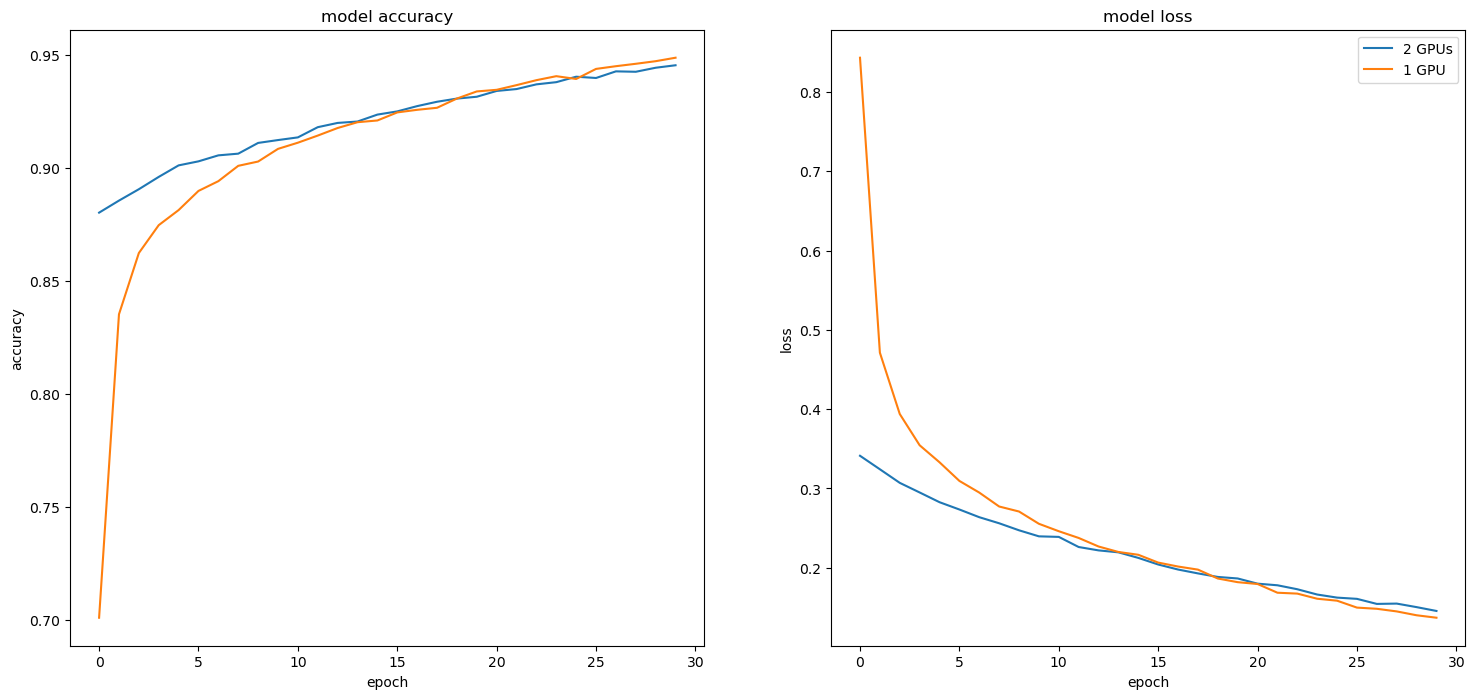

In [14]:
fig, axs = plt.subplots(1, 2,figsize=(18,8))
axs[0].plot(history_multi.history['accuracy'],label = '2 GPUs')
axs[0].plot(history_regular.history['accuracy'],label = '1 GPU')
axs[0].set_title('model accuracy')
axs[0].set_ylabel('accuracy')
axs[0].set_xlabel('epoch')


axs[1].plot(history_multi.history['loss'],label = '2 GPUs')
axs[1].plot(history_regular.history['loss'],label = '1 GPU')
axs[1].set_title('model loss')
axs[1].set_ylabel('loss')
axs[1].set_xlabel('epoch')

plt.legend()
plt.show()

### Computing Power Comparison

We achieve 69.89 percent of scaling


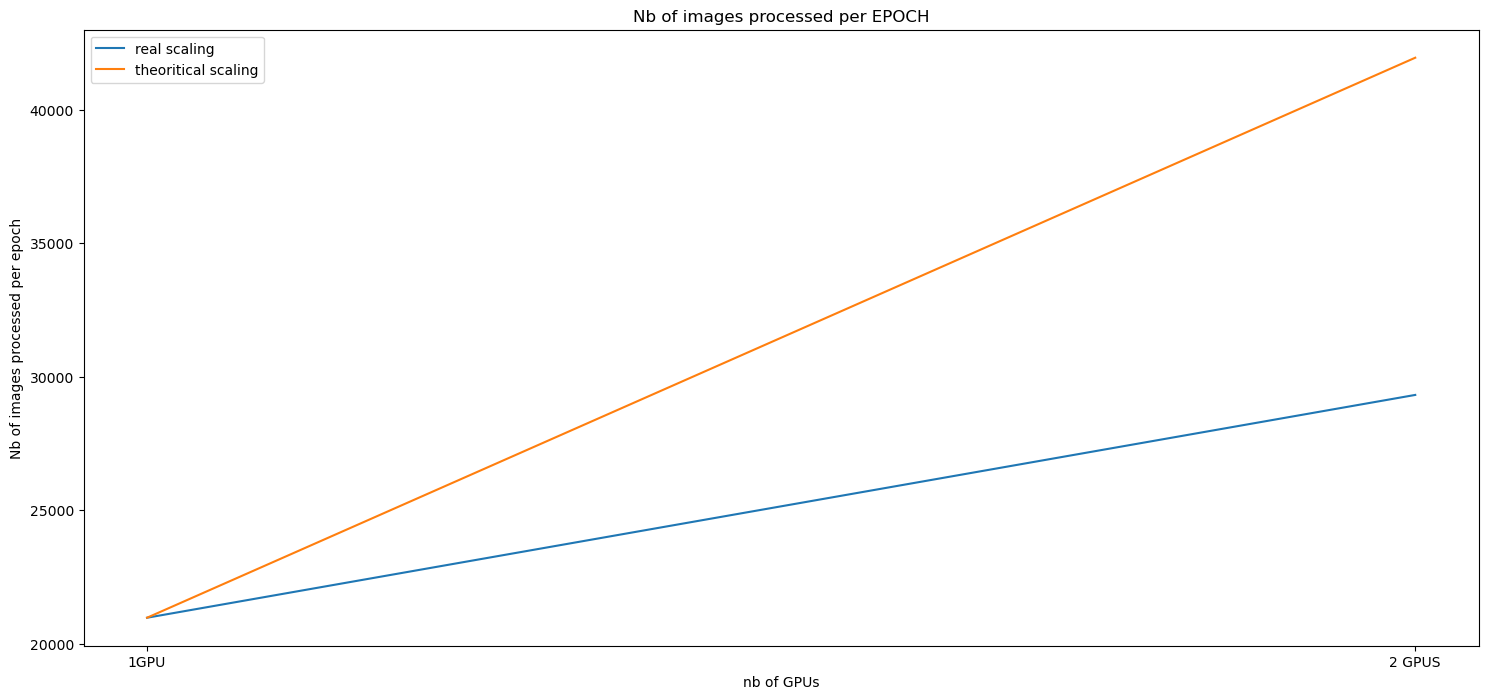

In [15]:
plt.figure(figsize=(18,8))
nb_images = len(train_data)
plt.plot(['1GPU','2 GPUS'],[nb_images/(final_time_single/EPOCHS),nb_images/(final_time_multi/EPOCHS)],label = 'real scaling')
plt.plot(['1GPU','2 GPUS'],[nb_images/(final_time_single/EPOCHS),2*nb_images/(final_time_single/EPOCHS)],label = 'theoritical scaling')
plt.title('Nb of images processed per EPOCH')
plt.ylabel('Nb of images processed per epoch')
plt.xlabel('nb of GPUs')
plt.legend()
print("We achieve %s percent of scaling"% round((final_time_single/(2*final_time_multi))*100,2))

When going from training with a single GPU to multiple GPUs on the same host, ideally we should experience the performance scaling with only the additional overhead of gradient communication and increased host thread utilization. Because of this overhead, we don't have an exact 2x speedup if we move from 1 to 2 GPUs.